# A Tutorial to Search for QPOs in Fast Transients with Fourier Periodogram

In this tutorial, we will look for quasi-periodic oscillations in fast transients, using traditional Fourier methods. This tutorial accompanies the paper *Searching for Quasi-Periodicities in Short Transients: The Curious Case of GRB 230307A* by Huppenkothen et al and is designed to give researchers a starting point for this kind of analysis.

We will use the INTEGRAL data for GRB 230307A as an example. 

## Imports

This tutorial primarily requires standard Python packages including `numpy`, `scipy`, `astropy`, and `matplotlib` for plotting. We also require the [`stingray` package](https://stingray.science) to compute periodograms and perform most of the analysis. Optionally, we use `seaborn` for prettier plots, but feel free to comment out the lines marked in the cell below.

In [6]:
import matplotlib.pyplot as plt

# Comment out the following two lines if you don't want to use seaborn
import seaborn as sns
sns.set_style('white')
######################

import numpy as np
import scipy
import scipy.stats

from astropy.modeling import models
from astropy.modeling.fitting import _fitter_to_model_params

import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params
from stingray import Powerspectrum
from stingray.modeling import PSDPosterior, PSDParEst
from stingray.modeling import set_logprior

# suppress warnings
import warnings
warnings.filterwarnings("ignore")


## Loading the Data

Let's set some directory paths for where we'll get the data from, and where we'll save the figures. You can point these to anywhere on your system (as long as the data is actually in the directory that `datadir` points at):

In [2]:
datadir = "../data/"
figdir = "../figures/"

Now we can load the data, create a `Lightcurve` object and compute the periodogram, using `stingray`'s `Powerspectrum` class. We will use a Leahy-normalized periodogram, as this normalization makes QPO searches relatively straightforward, because it is normalized such that pure photon noise will be distributed as $\chi^2$ with a mean of 2 and a variance of 4. Because for QPOs, the width of the QPO is often parametrized relative to the centroid frequency, we also generate a log-binned periodogram:

In [3]:
# Read the IDL .sav file with the data:
data = scipy.io.readsav(datadir+"acs_lc_bary.sav")

# extract the barycentred times of the time bins
barytime = np.array(data["barytime"], dtype=float)

# extract corresponding photon counts
counts = np.array(data["counts"], dtype=float)

# generate a `Lightcurve` object and compute the periodogram
lc = Lightcurve(barytime, counts)
ps = Powerspectrum(lc, norm="leahy")
ps_log = ps.rebin_log()

INFO[2025-01-29 11:56:13,443]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2025-01-29 11:56:13,443]: Checking if light curve is sorted.
INFO[2025-01-29 11:56:13,444]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


Let's plot the two to see what they look like:

Text(0, 0.5, 'Leahy-normalized Power')

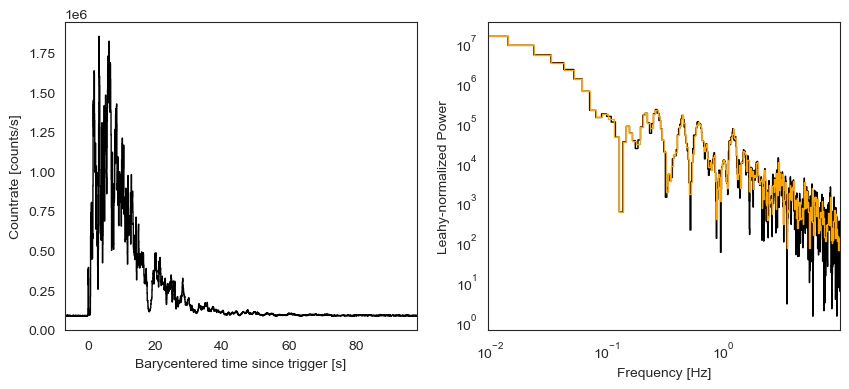

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.countrate, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.loglog(ps_log.freq, ps_log.power, ds="steps-mid", lw=1, color="orange")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power");

## Fitting a (broken) power law and looking for outliers

For our first analysis, we will follow the procedure of [Vaughan (2010]() and [Huppenkothen et al (2013)]().
First we fit a power law model as well as a broken power law model to the data. We then perform a Likelihood Ratio Test (LRT), calibrated with simulations from the simpler model, to figure out which broadband noise model is preferred for our data. We can then search for narrow QPOs by looking at the highest outlier in the data/model residuals, and compare that to the highest outliers derived from simulations.

### Power Law 

First, let's define a model that comprises a power law and a constant. We use the `astropy` modelling interface for that purpose:

In [7]:
# define power law component
pl = models.PowerLaw1D()

# fix x_0 of power law component
pl.x_0.fixed = True

# define constant
c = models.Const1D()

# make compound model
plc = pl + c

Next, we have to define priors for the model parameters. For the power law index and amplitude, we define relatively wide, uninformative flat priors. The prior for the amplitude should be a flat prior on the *log*-amplitude, but the `astropy` modelling interface makes that surprisingly annoying, so for now, we'll use a flat prior on the amplitude.

For the constant parametrizing the white noise, we use a Gaussian prior relatively closely centred around 2, which is where the white noise should be:

In [8]:
# flat prior for the power law index
p_alpha = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors = {}
priors["alpha_0"] = p_alpha
priors["amplitude_0"] = p_amplitude
priors["amplitude_1"] = p_whitenoise

We can now use the `stingray.modeling` interface to set up the model. First, we need a `PSDPosterior` object which parametrizes the correct likelihood for the periodogram, then set the priors, and print out some values for test parameters to see that everything works correctly:

In [11]:
lpost = PSDPosterior(ps.freq, ps.power, plc, m=ps.m)
lpost.logprior = set_logprior(lpost, priors)

test_pars = [1e4, 1.5, 2.0]
print("log-prior: " + str(lpost.logprior(test_pars)))
print("log-likelihood: " + str(lpost.loglikelihood(test_pars)))
print("log-posterior: " + str(lpost(test_pars)))

_fitter_to_model_params(plc, test_pars)

log-prior: 1.383646559789373
log-likelihood: -8758.839883394488
log-posterior: -8757.4562368347


Now we can do the parameter estimation, encodeded in the `PSDParEst` class. We'll use an optimizer to find the best-fit parameters, and plot the best-fit model:

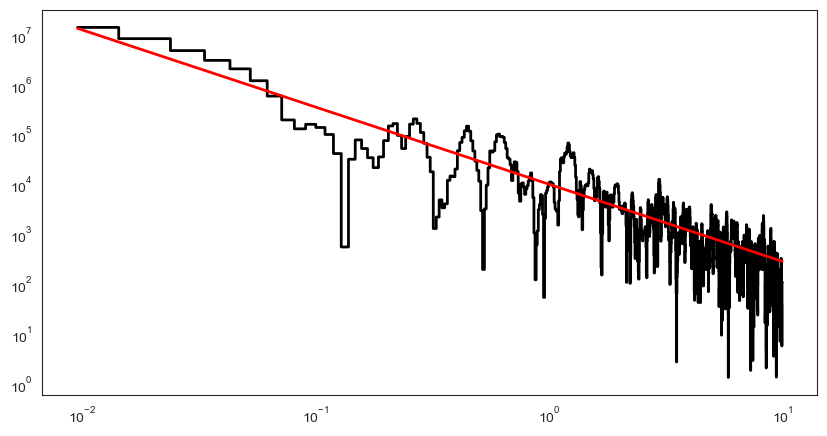

In [12]:
parest = PSDParEst(ps, fitmethod='l-bfgs-b', max_post=True)
res = parest.fit(lpost, test_pars)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")
ax.plot(ps.freq, res.mfit, lw=2, color="red")

In order to accurately account for the uncertainty in the model parameters, we will run Markov Chain Monte Carlo, as available in the `emcee` package. the `PSDParEst` class directly interfaces with that package:

In [13]:
sample = parest.sample(lpost, res.p_opt, cov=res.cov, nwalkers=100,
             niter=1000, burnin=3000, namestr="")

Chains too short to compute autocorrelation lengths.
INFO[2025-01-29 12:11:56,624]: Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.647210.5
INFO[2025-01-29 12:11:56,650]: -- The acceptance fraction is: 0.647210.5
R_hat for the parameters is: [6.98316324e+05 1.30273241e-03 1.02094200e-02]
INFO[2025-01-29 12:11:56,651]: R_hat for the parameters is: [6.98316324e+05 1.30273241e-03 1.02094200e-02]
-- Posterior Summary of Parameters: 

INFO[2025-01-29 12:11:56,653]: -- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO[2025-01-29 12:11:56,654]: parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO[2025-01-29 12:11:56,655]: ---------------------------------------------

theta[0] 	 14772.406222919168	839.7960857641035	13430.476945380242	16201.695457843336

INFO[2025-01-29 12:11:56,656]: theta[0] 	 14772.406222919168	839.7960857641035	13430.476945380242	16201.695457843336

theta[1] 	 1.74980192

Let's get out the posterior sample, and generate a corner or pair plot:

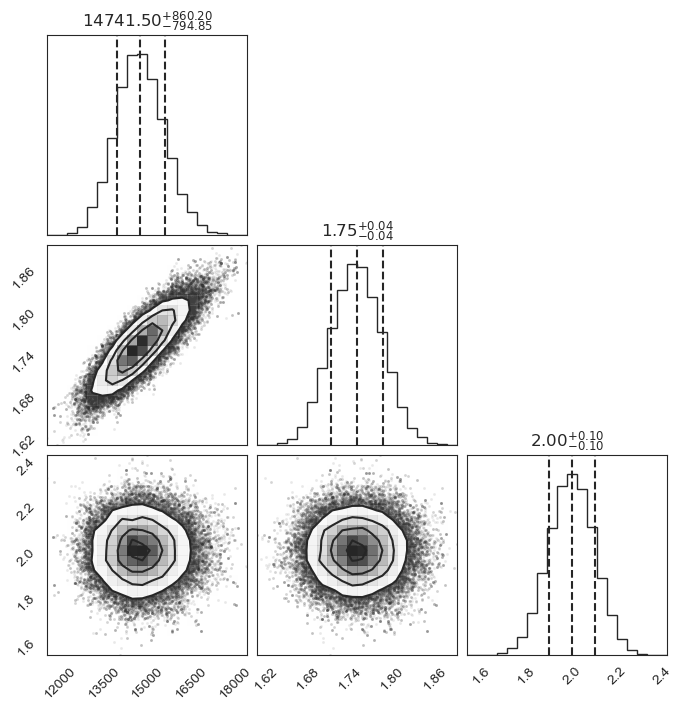

In [19]:
fig = sample.plot_results(nsamples=1000,save_plot=True,
                    filename="modeling_tutorial_mcmc_corner.pdf")


Overall the posterior distributions are well-constrained and unimodal (single-peaked). Note that the third parameter (the constant for the white noise) basically just reproduces the prior, because there is so much variability in the GRB that the periodogram never gets to the flat white noise level, and there is variability over all the frequencies in the periodogram. So there simply is no information in the data over where precisely the white noise level should be.

It is always a good idea to randomly draw points from the posterior, compute the model for those parameters, and overplot them over the data. This gives you an idea how close the model is to the data in general, and tells you something about the spread in models. To do that, draw random points from the posterior, compute the power law (plus constant) for those, and then plot the model with a lot of transparency (small `alpha`) to see where most of the models are:

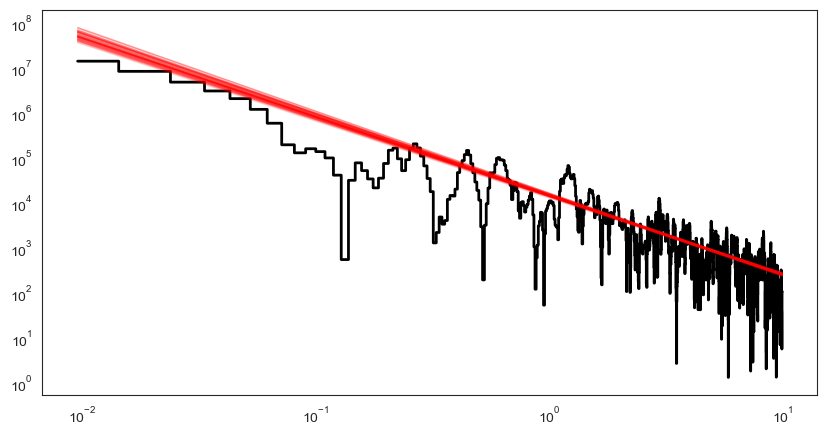

In [20]:
idx = np.random.choice(np.arange(post_samples.shape[0]), size=50, replace=False)


fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")


for i in idx:
    _fitter_to_model_params(plc, post_samples[i])
    ax.plot(ps.freq, plc(ps.freq) , lw=1, color="red", alpha=0.2)

### Broken Powerlaw Model

Let's compare this to a broken power law model, I think the power law may be overestimating the periodogram at the lowest frequencies. The process is exactly the same as for a power law, except with a different model from the `astropy.models` class.

Otherwise, we'll do exactly the same as before:
* define the model
* define prior distributions
* set up the `PSDPosterior` and `PSDParEst` classes

In [21]:
# broken power law model
bpl = models.BrokenPowerLaw1D()

# add constant
bplc = bpl + c

# flat prior for the power law indices
p_alpha1 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))
p_alpha2 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the break frequency
p_x_break = lambda xbreak: ((0.01 <= xbreak) & (10.0 >= xbreak))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

# put priors into dictionary
priors_bpl = {}
priors_bpl["alpha_1_0"] = p_alpha
priors_bpl["alpha_2_0"] = p_alpha

priors_bpl["amplitude_0"] = p_amplitude
priors_bpl["amplitude_1"] = p_whitenoise
priors_bpl["x_break_0"] = p_x_break

# set up posterior object
lpost_bplc = PSDPosterior(ps.freq, ps.power, bplc, priors=priors_bpl, m=ps.m)

# set up parameter estimation
parest = PSDParEst(ps, fitmethod='powell', max_post=False)
test_pars_bplc = [4e6, 0.05, 0.5, 1.7, 2.0]


From here, we'll do things slightly differently. In the `PSDParEst` class, there is a method called `compute_lrt` which will fit two different models to the data, and then compute the Likelihood Ratio between them. Let's do that, and then plot the two models:

Likelihood ratio: 0.8253592958244553


Text(0, 0.5, 'Leahy-normalized power')

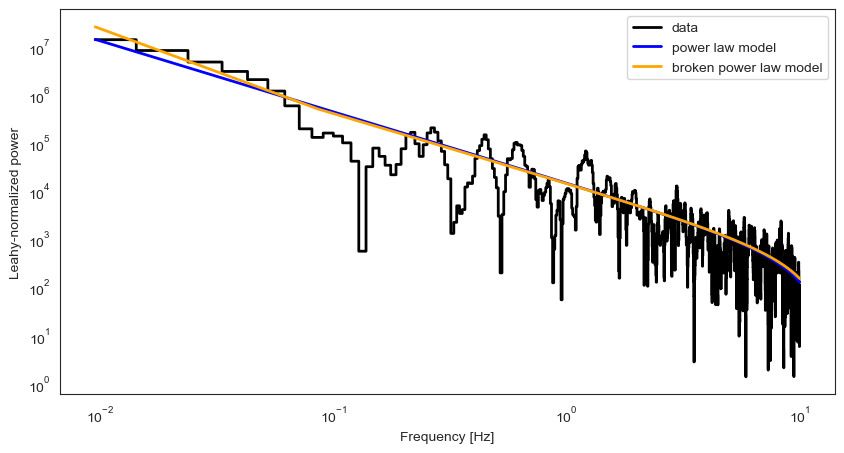

In [22]:
# compute likelihood ratio test
lrt, plc_opt, bplc_opt = parest.compute_lrt(lpost, test_pars, lpost_bplc, test_pars_bplc)

# set parameters in model object
print(f"Likelihood ratio: {lrt}")
_fitter_to_model_params(plc, plc_opt.p_opt)
_fitter_to_model_params(bplc, bplc_opt.p_opt)

# plot data and both models:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid", label="data")
ax.plot(ps.freq, plc(ps.freq) , lw=2, color="blue", label="power law model")
ax.plot(ps.freq, bplc(ps.freq) , lw=2, color="orange", label="broken power law model")
ax.legend()
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Leahy-normalized power")

The power law and broken power law models seem to produce pretty similar results, except at the lowest frequencies. Is that different enough to prefer the more complex broken power law model? 

To find out, we'll need to calibrate the likelihood ratio test, which only follows a well-defined distribution in some rare idealized cases. To calibrate it, we will do the following:
* draw $n_\mathrm{sim}$ random parameter sets from the posterior for the simpler (power law) model
* compute the model for each of these
* add noise to generate a simulated periodogram designed to mimic the real data
* fit each simulated periodogram with both the power law and broken power law model
* compute the LRT for each simulated periodogram

A histogram of these simulated LRTs provides an empirical distribution of the LRT test statistic under the assumption that the null hypothesis (the simpler model, i.e. the power law) is true. If the LRT for the observed data is an outlier for that distribution, we reject the null hypothesis and proceed with the more complex model (all statistical caveats related to frequentist hypothesis testing apply here, but we'll not get into those in this tutorial):

In [24]:
# we will simulate 100 periodograms, so first draw 1000 parameter sets:
nsim = 100
idx = np.random.choice(np.arange(post_samples.shape[0]), size=nsim, replace=False)
s_all = post_samples[idx,:]

There's also a helper method in `PSDParEst` to automatically generate simulated periodograms and, fit the two models and then compute the LRT for each, which will just return the sample of LRTs derived from the simulations:

In [25]:
lrt_sim = parest.simulate_lrts(s_all, lpost, test_pars,
                     lpost_bplc, test_pars_bplc)

In general, you'll want to do more than 100 simulations (I usually do a 1000), but for speed reasons, for this tutorial, we'll choose a smaller number:

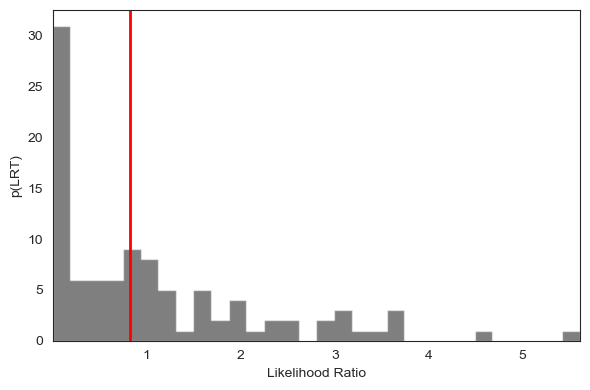

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(lrt_sim, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(lrt, lw=2, color="red")
ax.set_xlim(np.min(lrt_sim), np.max(lrt_sim))
ax.set_xlabel("Likelihood Ratio")
ax.set_ylabel("p(LRT)")
fig.tight_layout()
fig.savefig(figdir + "grb230307a_integral_pl_bpl_lrt.pdf", format="pdf")

The $p$-value is defined as the tail probability of observing a LRT at least as extreme or more extreme than the one derived from the real data, if the null hypothesis (the data was generated from the simpler power law model) was true. To compute this probability, count up all LRTs that are larger than the observed one, and divide by the total number of simulated LRTs:

In [27]:
np.sum(lrt_sim > lrt)/len(lrt_sim)

0.47

That p-value is very large, so we cannot reject the simpler model. For the QPO detection purposes, we'll continue with just a power law model.

## Highest Outlier

Generally, periodic and quasi-periodic signals concentrate power in a single or smalle number of frequency bins. One way to search especially for narrow (coherent) signals is to find the highest outlier in the periodogram above the broadband variability, and then ask the question of whether that outlier is expected given the statistical distribution of the periodogram ($\chi^2$ around the underlying broadband stochastic process). 

To compute the highest outlier, we first divide out the best-fit model, then find the highest outlier in the data/model residuals. As we've done with the likelihood ratio test, we also need to empirically calibrate the distribution to compare to, using simulations where we know there is *no* QPO present. 

Again, `stingray` provised convenience functions for this purpose:

In [28]:
t_sim = parest.simulate_highest_outlier(s_all, lpost, test_pars)

Let's plot this distribution, too. The highest outlier in the data/model residuals for the data was actually automatically computed when we did the Maximmum-A-Posteriori fit earlier, and we can get it out of the `results` object that the fitting method returned. 

Then, we combine the two by plotting the empirical distribution of maximum outliers with our observed value:

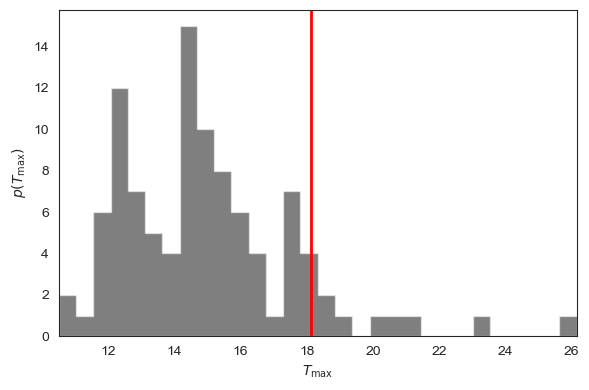

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(t_sim, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(res.maxpow, lw=2, color="red")
ax.set_xlim(np.min(t_sim), np.max(t_sim))
ax.set_xlabel(r"$T_{\mathrm{max}}$")
ax.set_ylabel(r"$p(T_{\mathrm{max}})$")
fig.tight_layout()
fig.savefig(figdir + "grb230307a_integral_pl_maxpost.pdf", format="pdf")

As with the likelihood ratio test, we can compute the p-value of observing an outlier in the periodogram as extreme or more extreme than the one derived from the real data, if the null hypothesis (no QPO) is true:

In [30]:
np.sum(t_sim > res.maxpow)/len(t_sim)

0.11

Again, this is not really significant. We cannot reject the null hypothesis that there is no QPO in the data.

## QPO Model Comparison

The method above, relying on outliers in the periodogram, works best if any putative signal is narrowly concentrated on one or very few frequency bins (i.e. is very coherent). However, QPOs can have a substantial width, and there were certainly features in the periodogram of the data that are reminiscent of broad QPOs. The outlier detection method is not very sensitive to those signals, since the power is spread over a larger range of frequency bins.

There are two options: we could bin the periodogram until all the relevant power is concentrated in one bin, and then re-run the outlier detection. Or we can do what we'll do below, and again set up a model comparison problem. This time, we'll compare our broadband model (power law) with a model that comprises both the same power law broadband model, and also a Lorentzian component for a QPO. The Lorentzian provides a much more flexible model than the outlier method, and is sensitive to much broader signals.

We'll do the likelihood ratio test, including its calibration on simulations, in the exact same way as above for the comparison between the power law and broken power law model.

First, let's set up the new model, and priors for the power law and Lorentzian parameters:

In [31]:
# power law and Lorentzian
qpoplc = models.PowerLaw1D() + models.Lorentz1D()

# fix x_0 of power law component
qpoplc.x_0_0.fixed = True

# flat prior for the power law indices
p_alpha0 = lambda alpha: ((-1. <= alpha) & (alpha <= 5.))

# flat prior for the power law amplitude
p_amplitude = lambda amplitude: ((1 <= amplitude) & (amplitude <= 1e8))

p_x0 = lambda x0: ((0.1 <= x0) & (x0 <= 2.5))
p_fwhm = lambda fwhm: ((0.001 <= fwhm) & (fwhm <= 1.0))

# normal prior for the white noise parameter
p_whitenoise = lambda white_noise: scipy.stats.norm(2.0, 0.1).pdf(white_noise)

priors_qpopl = {"amplitude_0": p_amplitude,
                "alpha_0": p_alpha0,
                "amplitude_1": p_amplitude,
                "x_0_1": p_x0,
                "fwhm_1": p_fwhm,
                }

Let's fit both models to the data, and compute the likelihood ratio:

[1.19947117e+04 1.64881372e+00 4.99880971e+04 1.21623011e+00
 8.31204557e-02]
Likelihood ratio: 24.471278635741328


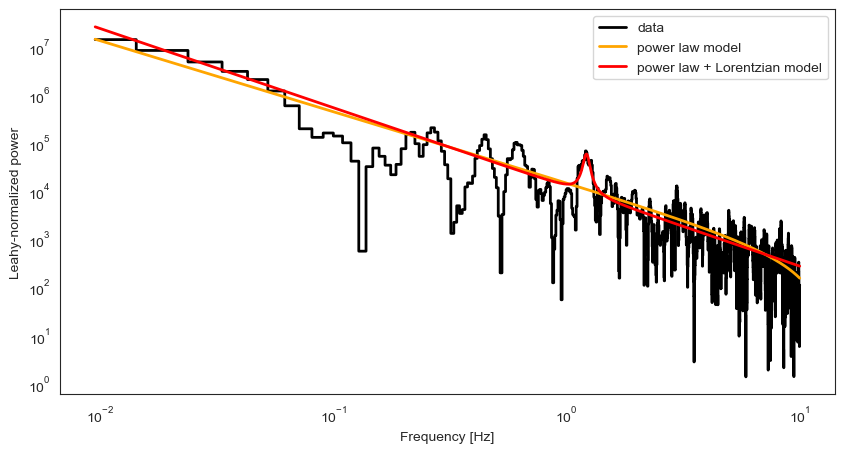

In [32]:
lpost_qpoplc = PSDPosterior(ps.freq, ps.power, qpoplc, priors=priors_qpopl, m=ps.m)

parest = PSDParEst(ps, fitmethod='bfgs', max_post=False)
test_pars_qpoplc = [1e4, 1.5, 5e4, 1.2, 0.1]

lrt, plc_opt, qpoplc_opt = parest.compute_lrt(lpost, test_pars, lpost_qpoplc, test_pars_qpoplc)
print(qpoplc_opt.p_opt)
print(f"Likelihood ratio: {lrt}")
_fitter_to_model_params(plc, plc_opt.p_opt)
_fitter_to_model_params(qpoplc, qpoplc_opt.p_opt)

fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid", label="data")
ax.plot(ps.freq, plc(ps.freq) , lw=2, color="orange", label="power law model")
ax.plot(ps.freq, qpoplc(ps.freq) , lw=2, color="red", label = "power law + Lorentzian model")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Leahy-normalized power")
ax.legend()

As you can see, the model containing a QPO optimized to fit one of those periodogram peaks. Let's calibrate the likelihood ratio using simulations. Again we'll use 100 simulations from the null hypothesis (only power law, no QPO), and then fit the simulated data with both models (just power law; power law + QPO):

In [33]:
lrt_sim_qpo = parest.simulate_lrts(s_all, lpost, test_pars,
                     lpost_qpoplc, test_pars_qpoplc)

Now we can plot the distribution of LRTs generated from periodograms that contain *no* QPO, and compare that to the LRT we've obtained when fitting the real data:

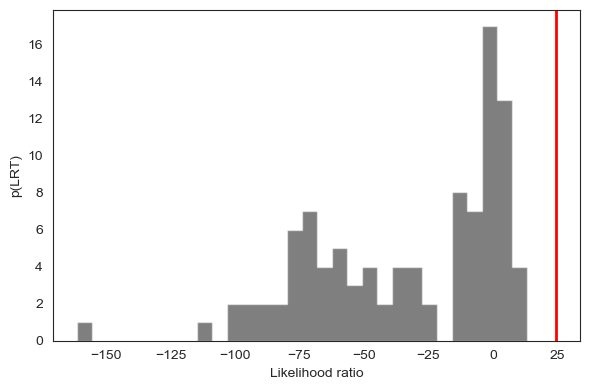

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(lrt_sim_qpo, bins=30, histtype="stepfilled", alpha=0.5, color="black")

ax.axvline(lrt, lw=2, color="red")
ax.set_xlabel("Likelihood ratio")
ax.set_ylabel("p(LRT)")
fig.tight_layout()
#fig.savefig(figdir + "grb230307a_integral_pl_qpopl_lrt.pdf", format="pdf")

In [35]:
np.sum(lrt_sim_qpo > lrt)/len(lrt_sim_qpo)

0.0

Okay, so $p < 0.01$. We can't do better than that by definition with only 100 simulations, so I'll encourage you to redo this with more simulated periodograms (at least 1000, so you can get to something like a $3\sigma$ threshold). I have done this (for the paper) with many additional simulations, so I know that it remains significant at that $3\sigma$ threshold. This would allow us to reject the null hypothesis that the data are consistent with just a power law, which would lead us to conclude that we need the presence of a QPO in the data.

That looks like there should be a QPO in the data. Note, however, that all the caveats of periodogram-based QPO searches mentioned in the paper that this notebook accompanies apply (the broadband noise models we use here are not a good match to fast transients), so please use this result with care. 

## QPO Parameter Posteriors

If we assume (for the moment) that the signal is real, we can run MCMC on the model with a power law and a QPO, and get posterior probabilities for the QPO parameters.

In [36]:
sample = parest.sample(lpost_qpoplc, qpoplc_opt.p_opt, nwalkers=100,
             niter=1000, burnin=3000, namestr="")

Chains too short to compute autocorrelation lengths.
INFO[2025-01-29 12:43:05,197]: Chains too short to compute autocorrelation lengths.
-- The acceptance fraction is: 0.457480.5
INFO[2025-01-29 12:43:05,232]: -- The acceptance fraction is: 0.457480.5
R_hat for the parameters is: [5.35185221e+05 1.27436746e-03 2.75035012e+10 2.50123671e-04
 2.15772267e-03]
INFO[2025-01-29 12:43:05,233]: R_hat for the parameters is: [5.35185221e+05 1.27436746e-03 2.75035012e+10 2.50123671e-04
 2.15772267e-03]
-- Posterior Summary of Parameters: 

INFO[2025-01-29 12:43:05,234]: -- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO[2025-01-29 12:43:05,235]: parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

INFO[2025-01-29 12:43:05,237]: ---------------------------------------------

theta[0] 	 12041.656385834365	735.2057446604827	10875.761993489608	13270.61174513461

INFO[2025-01-29 12:43:05,239]: theta[0] 	 12041.656385834365	735.2057446604827

WARNING[2025-01-29 12:44:54,656]: Too few points to create valid contours


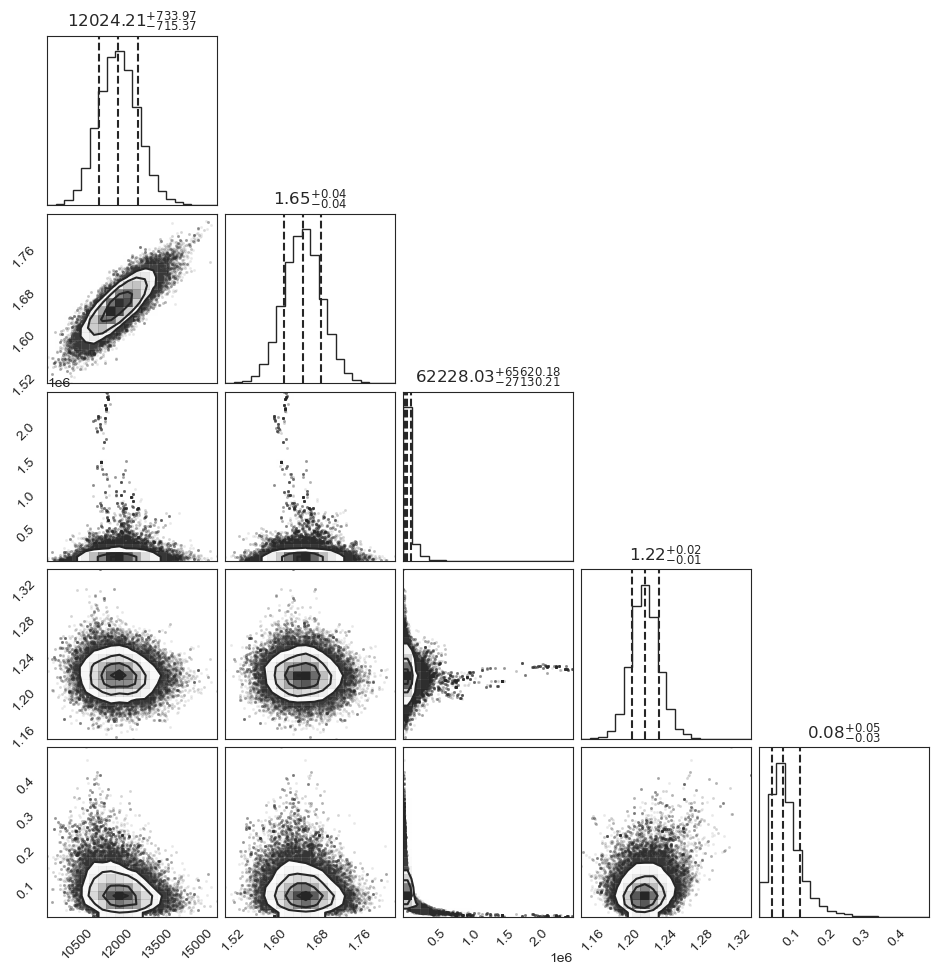

In [37]:
fig = plt.figure(figsize=(10,10))
fig = sample.plot_results(fig=fig)

Again, let's also plot posterior draws to see what the range of models looks like:

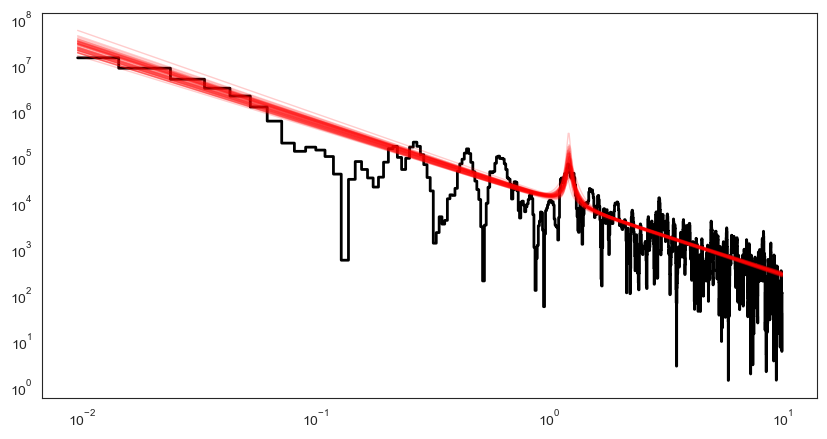

In [39]:
idx = np.random.choice(np.arange(sample.samples.shape[0]), size=50, replace=False)


fig, ax = plt.subplots(1, 1, figsize=(10,5))

ax.loglog(ps.freq, ps.power, lw=2, color="black", ds="steps-mid")


for i in idx:
    _fitter_to_model_params(qpoplc, sample.samples[i])
    ax.plot(ps.freq, qpoplc(ps.freq) , lw=1, color="red", alpha=0.2)